In [1]:
!pip -q install geopy
print('Install geopy')

!pip -q install geocoder
print('Install geocoder')

!pip -q install folium
print('Install folium')

Install geopy
Install geocoder
Install folium


In [2]:
# library for BeautifulSoup
from bs4 import BeautifulSoup

# library to handle data in a vectorized manner
import numpy as np

# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json
print('Import numpy, pandas')

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
print('Import Nominatim')

# library to handle requests
import requests
print('Import requests')

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
print('Import json_normalize')

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('Import matplotlib')

# import k-means from clustering stage
from sklearn.cluster import KMeans
print('Import Kmeans')

# import geocoder
import geocoder

# import time
import time

import folium # map rendering library
print('Import folium')
print('finished!')

Import numpy, pandas
Import Nominatim
Import requests
Import json_normalize
Import matplotlib
Import Kmeans
Import folium
finished!


In [3]:
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
wikipedia_page = requests.get(wikipedia_link, headers = headers)
wikipedia_page

<Response [200]>

In [4]:
# Cleans html file
wikifile = BeautifulSoup(wikipedia_page.content, 'html.parser')
# This extracts the "tbody" within the table where class is "wikitable sortable"
table = wikifile.find('table', {'class':'wikitable sortable'}).tbody

In [5]:
# Extracts all "tr" (table rows) within the table above
rows = table.find_all('tr')

In [6]:
# Extracts the column headers, removes and replaces possible '\n' with space for the "th" tag# Extra 
columns = [i.text.replace('\n', '')
           for i in rows[0].find_all('th')]

In [7]:
# Converts columns to pd dataframe
df = pd.DataFrame(columns = columns)
df

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref


In [8]:
# Extracts every row with corresponding columns# Extra 
# Then appends the values to the create pd dataframe "df"

for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    
    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text.replace('\n', ''.replace('\xa0','')), tds[3].text, tds[4].text.replace('\n', ''.replace('\xa0','')), tds[5].text.replace('\n', ''.replace('\xa0','')), tds[6].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n', '').replace('\xa0','') for td in tds]
        
        df = df.append(pd.Series(values, index = columns), ignore_index = True)

        df

In [9]:
df.head(5)

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [10]:
df = df.rename(index=str, columns = {'Location': 'Location', 'London\xa0borough': 'Borough', 'Post town': 'Post-town', 'Postcode\xa0district': 'Postcode', 'Dial\xa0code': 'Dial-code', 'OS grid ref': 'OSGridRef'})

In [11]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [12]:
df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [13]:
df.shape

(533, 6)

In [14]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [15]:
#Assumption 1
df0 = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))

In [16]:
df0.head(5)

,Location,Borough,Post-town,Dial-code,OSGridRef,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W4
10,Angel,Islington,LONDON,020,TQ345665,EC1
10,Angel,Islington,LONDON,020,TQ345665,N1


In [17]:
df0.shape

(637, 6)

In [18]:
#Assumption 2
df1 = df0[['Location', 'Borough', 'Postcode', 'Post-town']].reset_index(drop=True)

In [19]:
df1.head(5)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [20]:
df1.shape

(637, 4)

In [21]:
#Assumption 3
df2 = df1
df21 = df2[df2['Post-town'].str.contains('LONDON')]

In [22]:
df21.head(5)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [23]:
df21.shape

(381, 4)

In [24]:
# Re-assigns the df21 to new dataframe without the Post-town
df3 = df21[['Location', 'Borough', 'Postcode']].reset_index(drop=True)

In [25]:
df3.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1
5,Church End,Brent,NW10
6,Church End,Barnet,N3
7,Clapham,"Lambeth, Wandsworth",SW4
8,Clerkenwell,Islington,EC1
9,Colindale,Barnet,NW9


In [26]:
df_london = df3
df_london.to_csv('LondonLocations.csv', index = False)

In [28]:
#Assumption 4
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [29]:
df_london.Postcode = df_london.Postcode.str.strip()

In [30]:
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [31]:
# New dataframe for South East London postcodes - df_se
df_se = df_london[df_london['Postcode'].str.startswith(('SE'))].reset_index(drop=True)

In [32]:
df_se.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Crystal Palace,Bromley,SE20
5,Crystal Palace,Bromley,SE26
6,Denmark Hill,Southwark,SE5
7,Deptford,Lewisham,SE8
8,Dulwich,Southwark,SE21
9,East Dulwich,Southwark,SE22


In [35]:
#Assumption 5
demograph_link = 'https://en.wikipedia.org/wiki/Demography_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
demograph_page = requests.get(demograph_link, headers = headers)
soup1 = BeautifulSoup(demograph_page.content, 'html.parser')
table1 = soup1.find('table', {'class':'wikitable sortable'}).tbody
rows1 = table1.find_all('tr')
columns1 = [i.text.replace('\n', '')
           for i in rows1[0].find_all('th')]

In [36]:
columns1

['Local authority', 'White', 'Mixed', 'Asian', 'Black', 'Other']

In [37]:
demo_london = pd.DataFrame(columns = columns1)

In [38]:
demo_london.head(5)

,Local authority,White,Mixed,Asian,Black,Other


In [39]:
for j in range(1, len(rows1)):
    tds1 = rows1[j].find_all('td')
    if len(tds1) == 7:
        values1 = [tds1[0].text, tds1[1].text, tds1[2].text.replace('\n', ''.replace('\xa0','')), tds1[3].text, tds1[4].text.replace('\n', ''.replace('\xa0','')), tds1[5].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values1 = [td1.text.replace('\n', '').replace('\xa0','') for td1 in tds1]
        
        demo_london = demo_london.append(pd.Series(values1, index = columns1), ignore_index = True)

        demo_london

In [40]:
demo_london['Black'] = demo_london['Black'].astype('float')

In [41]:
demo_london_sorted = demo_london.sort_values(by='Black', ascending = False)

In [42]:
demo_london_sorted.head(5)

,Local authority,White,Mixed,Asian,Black,Other
22,Lewisham,53.5,7.4,9.3,27.2,2.6
27,Southwark,54.3,6.2,9.4,26.9,3.3
21,Lambeth,57.1,7.6,6.9,25.9,2.4
11,Hackney,54.7,6.4,10.5,23.1,5.3
7,Croydon,55.1,6.6,16.4,20.2,1.8


In [43]:
#Assumption 6
df_se

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Crystal Palace,Bromley,SE20
5,Crystal Palace,Bromley,SE26
6,Denmark Hill,Southwark,SE5
7,Deptford,Lewisham,SE8
8,Dulwich,Southwark,SE21
9,East Dulwich,Southwark,SE22


In [44]:
df_se_top = df_se[df_se['Borough'].isin(['Lewisham', 'Southwark', 'Lambeth', 'Hackney', 'Croydon'])].reset_index(drop=True)

In [45]:
df_se_top.head(5)

,Location,Borough,Postcode
0,Crofton Park,Lewisham,SE4
1,Denmark Hill,Southwark,SE5
2,Deptford,Lewisham,SE8
3,Dulwich,Southwark,SE21
4,East Dulwich,Southwark,SE22


In [46]:
df_se_top.shape

(46, 3)

In [47]:
df_se.shape

(80, 3)

In [48]:
# Dataset 2
# Geocoder starts here
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [49]:
sample = get_latlng('SE2')
sample

[51.492450000000076, 0.12127000000003818]

In [50]:
gg = geocoder.geocodefarm(sample, method = 'reverse')
gg

<[OK] Geocodefarm - Reverse [Harrow Manor Way, London, SE2 9SW, United Kingdom]>

In [51]:
start = time.time()

postal_codes = df_se_top['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  26.058440923690796 seconds


In [52]:
df_se_loc = df_se_top

# Obtained the coordinates (latitude and longitude) and joined with the dataframe 
df_se_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_se_loc['Latitude'] = df_se_coordinates['Latitude']
df_se_loc['Longitude'] = df_se_coordinates['Longitude']

In [53]:
df_se_loc.head(5)

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076


In [54]:
df_se_loc.to_csv('SELondonLocationsCoordinates.csv', index = False)

In [55]:
df_se_loc.shape

(46, 5)

In [56]:
# Dataset 3
# Foursquare client ID

CLIENT_ID = 'F1XF3RJK4NWBPDRM2ZXJWN3LDDOU43MZVENKNEXHC4QJPNIW' # your Foursquare ID
CLIENT_SECRET = 'ACHLIPZQ5FPICDAVIVTSMS5O1ZKL4XV42U3FPUFXUPKKGXPB' # your Foursquare Secret

VERSION = '20180604'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: F1XF3RJK4NWBPDRM2ZXJWN3LDDOU43MZVENKNEXHC4QJPNIW
CLIENT_SECRET:ACHLIPZQ5FPICDAVIVTSMS5O1ZKL4XV42U3FPUFXUPKKGXPB


In [57]:
# Data Exploration

In [58]:
# 2.4.1.1.	Single Neighborhood

# Resets the current index to a new
se_df = df_se_loc.reset_index().drop('index', axis = 1)

In [59]:
se_df.shape

(46, 5)

In [60]:
se_df

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076
5,Elephant and Castle,Southwark,SE1,51.49960,-0.09613
6,Elephant and Castle,Southwark,SE11,51.49084,-0.11108
7,Elephant and Castle,Southwark,SE17,51.48764,-0.09542
8,Bankside,Southwark,SE1,51.49960,-0.09613
9,Forest Hill,Lewisham,SE23,51.44122,-0.04764


In [61]:
se_df.loc[se_df['Location'] == 'Lewisham']

,Location,Borough,Postcode,Latitude,Longitude
20,Lewisham,Lewisham,SE13,51.46196,-0.00754


In [62]:
se_df.loc[20, 'Location']

'Lewisham'

In [63]:
lewisham_lat = se_df.loc[20, 'Latitude']
lewisham_long = se_df.loc[20, 'Longitude']
lewisham_loc = se_df.loc[20, 'Location']
lewisham_postcode = se_df.loc[20, 'Postcode']

print('The latitude and longitude values of {} with postcode {}, are {}, {}.'.format(lewisham_loc,
                                                                                         lewisham_postcode,
                                                                                         lewisham_lat,
                                                                                         lewisham_long))

The latitude and longitude values of Lewisham with postcode SE13, are 51.46196000000003, -0.007539999999949032.


In [64]:
# Credentials are provided already for this part
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lewisham_lat, 
    lewisham_long, 
    radius, 
    LIMIT)

# displays URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=F1XF3RJK4NWBPDRM2ZXJWN3LDDOU43MZVENKNEXHC4QJPNIW&client_secret=ACHLIPZQ5FPICDAVIVTSMS5O1ZKL4XV42U3FPUFXUPKKGXPB&v=20180604&ll=51.46196000000003,-0.007539999999949032&radius=2000&limit=100'

In [65]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e63fb6e78a484001b8c59ca'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Lewisham Central',
  'headerFullLocation': 'Lewisham Central, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 183,
  'suggestedBounds': {'ne': {'lat': 51.47996001800005,
    'lng': 0.021296961190459426},
   'sw': {'lat': 51.44395998200002, 'lng': -0.03637696119035749}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '535823bc498ec8d8da9aad5f',
       'name': 'Street Feast Model Market',
       'location': {'address': '196 Lewisham High St',
        'crossStreet': 'entrance at Molesworth St',
        'lat': 51.46020945743763,
        'lng': -0.01

In [66]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [67]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [68]:
nearby_venues

,name,categories,lat,lng
0,Street Feast Model Market,Street Food Gathering,51.460209,-0.012199
1,Maggie's Kitchen,Café,51.465380,-0.011213
2,Levante restaurant,Restaurant,51.462072,-0.009491
3,Levante Pide Restaurant,Turkish Restaurant,51.459848,-0.011476
4,Corte,Coffee Shop,51.459776,-0.011554
5,Manor House Gardens,Park,51.456686,0.004684
6,Dirty South,Pub,51.458846,-0.002666
7,Côte Brasserie,French Restaurant,51.467378,0.007176
8,Blackheath Farmers' Market,Farmers Market,51.465913,0.007945
9,Gennaro Delicatessan,Deli / Bodega,51.461765,-0.009726


In [69]:
nearby_venues_lewisham_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')

In [70]:
nearby_venues_lewisham_unique.head(5)

,Count
Pub,13
Café,8
Gastropub,7
Park,5
Garden,4


In [71]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [72]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [73]:
se_venues = getNearbyVenues(names=se_df['Location'],
                                   latitudes=se_df['Latitude'],
                                   longitudes=se_df['Longitude']
                                  )

Crofton Park
Denmark Hill
Deptford
Dulwich
East Dulwich
Elephant and Castle
Elephant and Castle
Elephant and Castle
Bankside
Forest Hill
Gipsy Hill
Gipsy Hill
Grove Park
Herne Hill
Hither Green
Honor Oak
Ladywell
Ladywell
Lambeth
Lee
Lewisham
New Cross
Newington
Newington
Nunhead
Oval
Bellingham
Peckham
Rotherhithe
Selhurst
Bermondsey
South Norwood
Southend
St Johns
Surrey Quays
Tulse Hill
Tulse Hill
Upper Norwood
Walworth
Blackheath
West Norwood
Brixton
Brockley
Camberwell
Catford
Chinbrook


In [74]:
se_venues.shape

(4230, 7)

In [75]:
len(se_venues)

4230

In [76]:
se_venues['Neighbourhood'].value_counts()
se_venues.to_csv('se_venues.csv')

In [77]:
se_venues.head(5)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Crofton Park,51.46268,-0.03558,The Orchard,51.463678,-0.035699,Gastropub
1,Crofton Park,51.46268,-0.03558,Brockley's Rock,51.459457,-0.033868,Fish & Chips Shop
2,Crofton Park,51.46268,-0.03558,Browns Of Brockley,51.464513,-0.037346,Coffee Shop
3,Crofton Park,51.46268,-0.03558,Waterintobeer,51.463712,-0.038826,Beer Store
4,Crofton Park,51.46268,-0.03558,Saka Maka,51.464826,-0.036437,Indian Restaurant


In [78]:
se_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Bankside,100,100,100,100,100,100
Bellingham,68,68,68,68,68,68
Bermondsey,100,100,100,100,100,100
Blackheath,91,91,91,91,91,91
Brixton,100,100,100,100,100,100
Brockley,100,100,100,100,100,100
Camberwell,100,100,100,100,100,100
Catford,68,68,68,68,68,68
Chinbrook,50,50,50,50,50,50


In [79]:
print('There are {} uniques categories.'.format(len(se_venues['Venue Category'].unique())))

There are 199 uniques categories.


In [80]:
se_venue_unique_count = se_venues['Venue Category'].value_counts().to_frame(name='Count')

In [81]:
se_venue_unique_count.head(5)

,Count
Pub,435
Coffee Shop,292
Café,266
Park,201
Grocery Store,145


In [82]:
se_venue_unique_count.describe()

,Count
count,199.000000
mean,21.256281
std,47.157587
min,1.000000
25%,4.000000
50%,7.000000
75%,19.000000
max,435.000000


In [83]:
# Map Visualization

address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [84]:
# df_london_coordinates# df_lon 
map_london = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_london

In [85]:
# Adding markers to map
for lat, lng, borough, loc in zip(se_df['Latitude'], 
                                  se_df['Longitude'],
                                  se_df['Borough'],
                                  se_df['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

In [86]:
type(se_df)

pandas.core.frame.DataFrame

In [87]:
# 2.5.3. Analyzing Each Neighborhood

In [88]:
# one hot encoding# one ho 
se_onehot = pd.get_dummies(se_venues[['Venue Category']], prefix = "", prefix_sep = "")

In [89]:
# add neighborhood column back to dataframe
se_onehot['Neighbourhood'] = se_venues['Neighbourhood']

In [90]:
# move neighborhood column to the first column# move n 
fixed_columns = [se_onehot.columns[-1]] + list(se_onehot.columns[:-1])
se_onehot = se_onehot[fixed_columns]

In [91]:
se_onehot.head(5)

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Office,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sake Bar,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [92]:
se_onehot.loc[se_onehot['African Restaurant'] != 0]

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Office,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sake Bar,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
137,Denmark Hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
646,Elephant and Castle,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
727,Elephant and Castle,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [93]:
se_onehot.loc[se_onehot['Neighbourhood'] == 'Lewisham']

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Office,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sake Bar,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
1881,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1882,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1883,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,

In [94]:
se_onehot.to_csv('selondon_onehot.csv', index = False)

In [95]:
se_onehot.shape

(4230, 200)

In [96]:
# Regrouping and Category Statistics

se_grouped = se_onehot.groupby('Neighbourhood').mean().reset_index()
se_grouped.head()

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Office,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sake Bar,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Bankside,0.00,0.000000,0.0,0.0,0.000000,0.01,0.03,0.0,0.02,0.0,0.0,0.0,0.020000,0.020000,0.01,0.00,0.0,0.01,0.01,0.01,0.01,0.0,0.000000,0.01,0.02,0.0,0.000000,0.010000,0.0,0.0,0.00,0.01,0.000000,0.0,0.000000,0.030000,0.080000,0.0,0.00,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.01,0.01,0.0,0.00,0.0,0.00,0.0,0.010000,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.010000,0.0,0.000000,0.00,0.020000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.020000,0.010000,0.010000,0.0,0.0,0.000000,0.000000,0.000000,0.01,0.0,0.070000,0.01,0.0,0.01,0.000000,0.0,0.01,0.000000,0.000000,0.050000,0.000000,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.01,0.0,0.01,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.010000,0.070000,0.0,0.00,0.00,0.000000,0.010000,0.0,0.000000,0.0,0.000000,0.03,0.0,0.03,0.01,0.000000,0.000000,0.01,0.000000,0.000000,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.02,0.000000,0.0,0.0,0.01,0.000000,0.040000,0.0,0.0,0.0,0.0,0.010000,0.000000,0.0,0.000000,0.01,0.01,0.000000,0.0,0.020000,0.0,0.00

In [97]:
print("Before One-hot encoding:", se_df.shape)
print("After One-hot encoding:", se_grouped.shape)

Before One-hot encoding: (46, 5)
After One-hot encoding: (40, 200)


In [98]:
se_grouped.to_csv('london_grouped.csv', index = False)

In [99]:
num_top_venues = 10 # Top common venues needed

for hood in se_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = se_grouped[se_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Bankside----
                venue  freq
0         Coffee Shop  0.08
1               Hotel  0.07
2                 Pub  0.07
3  Italian Restaurant  0.05
4             Theater  0.04
5      Scenic Lookout  0.03
6          Art Museum  0.03
7        Cocktail Bar  0.03
8  Seafood Restaurant  0.03
9       Grocery Store  0.02


----Bellingham----
                  venue  freq
0         Grocery Store  0.12
1           Supermarket  0.09
2                  Park  0.07
3                  Café  0.06
4  Fast Food Restaurant  0.04
5           Coffee Shop  0.04
6    Italian Restaurant  0.04
7                   Pub  0.04
8         Train Station  0.03
9    Chinese Restaurant  0.03


----Bermondsey----
                venue  freq
0         Coffee Shop  0.08
1               Hotel  0.07
2                 Pub  0.07
3  Italian Restaurant  0.05
4             Theater  0.04
5      Scenic Lookout  0.03
6          Art Museum  0.03
7        Cocktail Bar  0.03
8  Seafood Restaurant  0.03
9       Grocery Store  

In [100]:
# Creating new dataframe

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [101]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = se_grouped['Neighbourhood']

for ind in np.arange(se_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(se_grouped.iloc[ind, :], num_top_venues)

In [102]:
neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bankside,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Art Museum,Cocktail Bar,Scenic Lookout,Seafood Restaurant,Garden
1,Bellingham,Grocery Store,Supermarket,Park,Café,Fast Food Restaurant,Pub,Italian Restaurant,Coffee Shop,Train Station,Chinese Restaurant
2,Bermondsey,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Art Museum,Cocktail Bar,Scenic Lookout,Seafood Restaurant,Garden
3,Blackheath,Pub,Grocery Store,Coffee Shop,Park,Clothing Store,Italian Restaurant,Supermarket,Garden,Bakery,Café
4,Brixton,Café,Coffee Shop,Park,Pub,Middle Eastern Restaurant,Indian Restaurant,Cocktail Bar,Italian Restaurant,Brewery,Pizza Place


In [103]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)

In [104]:
se_grouped_clustering = se_grouped.drop('Neighbourhood', 1)

In [105]:
# Clustering of Neighbourhoods

# set number of clusters# set num 
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(se_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 0, 1, 4, 1, 4, 3, 2, 1], dtype=int32)

In [106]:
kmeans.labels_[0:10]

array([0, 3, 0, 1, 4, 1, 4, 3, 2, 1], dtype=int32)

In [107]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [108]:
se_merged = se_df

In [109]:
se_merged.head(3)

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467


In [110]:
# match/merge SE London data with latitude/longitude for each neighborhood# match/m 
se_merged_latlong = se_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')

In [111]:
se_merged_latlong.head(5)

,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558,1,Pub,Coffee Shop,Café,Park,Gastropub,Bar,Indian Restaurant,Italian Restaurant,Cocktail Bar,Restaurant
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313,4,Café,Coffee Shop,Park,Pub,Middle Eastern Restaurant,Indian Restaurant,Cocktail Bar,Italian Restaurant,Brewery,Pizza Place
2,Deptford,Lewisham,SE8,51.48114,-0.02467,1,Pub,Café,Coffee Shop,Bar,Park,Brewery,Sandwich Place,Italian Restaurant,History Museum,Historic Site
3,Dulwich,Southwark,SE21,51.44100,-0.08897,1,Pub,Café,Bakery,Grocery Store,Park,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Farmers Market,Pizza Place
4,East Dulwich,Southwark,SE22,51.45256,-0.07076,4,Pub,Café,Pizza Place,Gastropub,Park,Italian Restaurant,Mediterranean Restaurant,Cocktail Bar,Restaurant,Coffee Shop


In [112]:
se_clusters = se_merged_latlong

In [113]:
# Optimal Number of Clusters for K-mean

In [114]:
# Elbow Method

%matplotlib inline
import matplotlib
import numpy as np

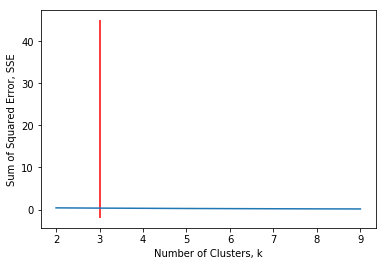

In [115]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SSE is initialize with empty values
# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2, 10):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(se_grouped_clustering)
    se_grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
# vertical line
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

In [116]:
# Silhouette Coefficient

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2, 10):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(se_grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(se_grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.5406791449269137
Where n_clusters = 3, the Silhouette Coefficient is 0.6284064510414675
Where n_clusters = 4, the Silhouette Coefficient is 0.6577333081545534
Where n_clusters = 5, the Silhouette Coefficient is 0.6830670547523618
Where n_clusters = 6, the Silhouette Coefficient is 0.7649714017214924
Where n_clusters = 7, the Silhouette Coefficient is 0.8383550559700208
Where n_clusters = 8, the Silhouette Coefficient is 0.8576859009003363
Where n_clusters = 9, the Silhouette Coefficient is 0.9324727464116009


In [117]:
se_clusters.columns

Index(['Location', 'Borough', 'Postcode', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [118]:
# Visualizing the Resulting Clusters

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(se_clusters['Latitude'], se_clusters['Longitude'], se_clusters['Location'], se_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

In [119]:
# Cluster 1

se_clusters.loc[se_clusters['Cluster Labels'] == 0, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Southwark,0,Pub,Café,Coffee Shop,Hotel,Italian Restaurant,Theater,Park,Pizza Place,Street Food Gathering,Garden
6,Southwark,0,Pub,Café,Coffee Shop,Hotel,Italian Restaurant,Theater,Park,Pizza Place,Street Food Gathering,Garden
7,Southwark,0,Pub,Café,Coffee Shop,Hotel,Italian Restaurant,Theater,Park,Pizza Place,Street Food Gathering,Garden
8,Southwark,0,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Art Museum,Cocktail Bar,Scenic Lookout,Seafood Restaurant,Garden
18,Lambeth,0,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Art Museum,Cocktail Bar,Scenic Lookout,Seafood Restaurant,Garden
22,Southwark,0,Pub,Coffee Shop,Hotel,Italian Restaurant,Café,Theater,Cocktail Bar,Pizza Place,Brewery,Garden
23,Southwark,0,Pub,Coffee Shop,Hotel,Italian Restaurant,Café,Theater,Cocktail Bar,Pizza Place,Brewery,Garden
30,Southwark,0,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Art Museum,Cocktail Bar,Scenic Lookout,Seafood Restaurant,Garden


In [120]:
#Clusters 2

se_clusters.loc[se_clusters['Cluster Labels'] == 1, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lewisham,1,Pub,Coffee Shop,Café,Park,Gastropub,Bar,Indian Restaurant,Italian Restaurant,Cocktail Bar,Restaurant
2,Lewisham,1,Pub,Café,Coffee Shop,Bar,Park,Brewery,Sandwich Place,Italian Restaurant,History Museum,Historic Site
3,Southwark,1,Pub,Café,Bakery,Grocery Store,Park,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Farmers Market,Pizza Place
9,Lewisham,1,Pub,Coffee Shop,Café,Grocery Store,Park,Supermarket,Gym / Fitness Center,Japanese Restaurant,Pizza Place,Pharmacy
10,Lambeth,1,Pub,Coffee Shop,Grocery Store,Café,Park,Bakery,Italian Restaurant,Pizza Place,Train Station,Gym / Fitness Center
11,Lambeth,1,Pub,Coffee Shop,Grocery Store,Café,Park,Bakery,Italian Restaurant,Pizza Place,Train Station,Gym / Fitness Center
14,Lewisham,1,Pub,Café,Gastropub,Park,Garden,Food Truck,Fish & Chips Shop,Coffee Shop,Restaurant,Turkish Restaurant
15,Lewisham,1,Pub,Coffee Shop,Café,Grocery Store,Park,Supermarket,Gym / Fitness Center,Japanese Restaurant,Pizza Place,Pharmacy
16,Lewisham,1,Pub,Coffee Shop,Café,Gastropub,Park,Bar,Restaurant,Italian Restaurant,Food Truck,Fish & Chips Shop
17,Lewisham,1,Pub,Coffee Shop,Café,Gastropub,Park,Bar,Restaurant,Italian Restaurant,Food Truck,Fish & Chips Shop


In [121]:
# Cluster 3

se_clusters.loc[se_clusters['Cluster Labels'] == 2, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Lewisham,2,Grocery Store,Pub,Park,Café,Supermarket,Italian Restaurant,Soccer Field,Coffee Shop,Train Station,Indian Restaurant
19,Lewisham,2,Grocery Store,Pub,Park,Café,Supermarket,Italian Restaurant,Soccer Field,Coffee Shop,Train Station,Indian Restaurant
45,Lewisham,2,Grocery Store,Pub,Park,Café,Supermarket,Italian Restaurant,Soccer Field,Coffee Shop,Train Station,Indian Restaurant


In [122]:
# Cluster 4

se_clusters.loc[se_clusters['Cluster Labels'] == 3, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Lewisham,3,Grocery Store,Supermarket,Park,Café,Fast Food Restaurant,Pub,Italian Restaurant,Coffee Shop,Train Station,Chinese Restaurant
29,Croydon,3,Pub,Grocery Store,Platform,Café,Park,Supermarket,Coffee Shop,Clothing Store,Caribbean Restaurant,Chinese Restaurant
31,Croydon,3,Pub,Grocery Store,Platform,Café,Park,Supermarket,Coffee Shop,Clothing Store,Caribbean Restaurant,Chinese Restaurant
32,Lewisham,3,Grocery Store,Supermarket,Park,Café,Fast Food Restaurant,Pub,Italian Restaurant,Coffee Shop,Train Station,Chinese Restaurant
44,Lewisham,3,Grocery Store,Supermarket,Park,Café,Fast Food Restaurant,Pub,Italian Restaurant,Coffee Shop,Train Station,Chinese Restaurant


In [123]:
# Cluster 5

se_clusters.loc[se_clusters['Cluster Labels'] == 4, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Southwark,4,Café,Coffee Shop,Park,Pub,Middle Eastern Restaurant,Indian Restaurant,Cocktail Bar,Italian Restaurant,Brewery,Pizza Place
4,Southwark,4,Pub,Café,Pizza Place,Gastropub,Park,Italian Restaurant,Mediterranean Restaurant,Cocktail Bar,Restaurant,Coffee Shop
13,Lambeth,4,Coffee Shop,Pub,Café,Market,Pizza Place,Brewery,Tapas Restaurant,Bakery,Park,Restaurant
24,Southwark,4,Pub,Pizza Place,Café,Park,Coffee Shop,Bar,Gastropub,Burger Joint,Cocktail Bar,Italian Restaurant
27,Southwark,4,Pub,Pizza Place,Café,Park,Coffee Shop,Bar,Gastropub,Burger Joint,Cocktail Bar,Italian Restaurant
41,Lambeth,4,Café,Coffee Shop,Park,Pub,Middle Eastern Restaurant,Indian Restaurant,Cocktail Bar,Italian Restaurant,Brewery,Pizza Place
43,Southwark,4,Café,Coffee Shop,Park,Pub,Middle Eastern Restaurant,Indian Restaurant,Cocktail Bar,Italian Restaurant,Brewery,Pizza Place
